In [5]:
%load_ext autoreload

In [6]:
# Instead of defining functions here, import them!
import sys
sys.path.append('..') # Allow importing from src folder

from src.data_loader import download_data_pipeline
from src.utils import get_spark_session

# 1. Download Data
download_data_pipeline()

# 2. Start Spark
spark = get_spark_session()

Prix2022S1.csv.gz already exists.
Prix2022S2.csv.gz already exists.
Prix2023.csv.gz already exists.
Prix2024.csv.gz already exists.
Stations2024.csv.gz already exists.
Services2024.csv.gz already exists.


In [7]:
%reload_ext autoreload
%autoreload 2

import sys, os
sys.path.append('..')
from src.data_loader import download_data_pipeline, load_config
from src.utils import get_spark_session
from src.preprocessing import load_and_clean_data
from pyspark.sql.functions import col, avg, lit

config = load_config()

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
data_path = os.path.join(project_root, config['data_settings']['directory'])

In [9]:
processed_path = "data/processed/gas_data_clean.parquet"

try:
    # Try to load preprocessed data (fast path)
    df = spark.read.parquet(processed_path)
    print("Loaded cached processed data.")

except Exception as e:
    # If it does not exist or is corrupted → recompute
    print("Processed data not found. Running preprocessing pipeline...")

    df = load_and_clean_data(spark, data_path, config)

    df.write.mode("overwrite").parquet(processed_path)
    print("Processed data saved to disk.")

# Trigger computation (Spark is lazy)
df.show(5)


Loaded cached processed data.
+-------+----+---+------+-----+-------------------+----+------+-----+-------------------+----------+----+-----+----+
|     id|  cp|pop|   lat| long|               date|type|  name| prix|        date_parsed|  day_date|year|month|week|
+-------+----+---+------+-----+-------------------+----+------+-----+-------------------+----------+----+-----+----+
|1000001|1000|  R|46.201|5.198|2022-01-03 08:44:18|   1|Gazole|1.572|2022-01-03 08:44:18|2022-01-03|2022|    1|   1|
|1000001|1000|  R|46.201|5.198|2022-01-05 10:08:11|   1|Gazole| 1.56|2022-01-05 10:08:11|2022-01-05|2022|    1|   1|
|1000001|1000|  R|46.201|5.198|2022-01-10 10:09:08|   1|Gazole|1.603|2022-01-10 10:09:08|2022-01-10|2022|    1|   2|
|1000001|1000|  R|46.201|5.198|2022-01-17 12:34:42|   1|Gazole|1.616|2022-01-17 12:34:42|2022-01-17|2022|    1|   3|
|1000001|1000|  R|46.201|5.198|2022-01-17 12:34:44|   1|Gazole|1.616|2022-01-17 12:34:44|2022-01-17|2022|    1|   3|
+-------+----+---+------+-----+---

In [10]:
df.createOrReplaceTempView("gas_raw")

In [11]:
# Analyze Gas Types
print("Distribution of Gas Types:")
gas_counts = df.groupBy("name").count().orderBy("count", ascending=True)
gas_counts.show()

Distribution of Gas Types:


+------+-------+
|  name|  count|
+------+-------+
|  GPLc| 619759|
|  SP95| 961020|
|   E85|1390580|
|  SP98|3425844|
|   E10|3559498|
|Gazole|4245380|
+------+-------+



In [12]:
# DECISION: We see that GPLc and E85 are very low volume.
# Let's filter them out as requested.
least_frequent = gas_counts.take(2)
low_interest_types = [row['name'] for row in least_frequent]
print(f"Dropping: {low_interest_types}")

df_filtered = df.filter(~col("name").isin(low_interest_types))

Dropping: ['GPLc', 'SP95']


In [13]:
gas_counts = df_filtered.groupBy("name").count().orderBy("count", ascending=True)
gas_counts.show()

+------+-------+
|  name|  count|
+------+-------+
|   E85|1390580|
|  SP98|3425844|
|   E10|3559498|
|Gazole|4245380|
+------+-------+



In [14]:

# Makes the data available as a table for SQL operations
df_filtered.createOrReplaceTempView("gas_prices")

# Show the filtered data
df_filtered.orderBy("date").select("id", "name", "prix", "year", "week").show(5)

+--------+------+-----+----+----+
|      id|  name| prix|year|week|
+--------+------+-----+----+----+
|18230004|Gazole|1.456|2022|  52|
|33310006|  SP98|1.841|2022|  52|
|18230004|   E10|1.522|2022|  52|
|18230004|  SP98|1.606|2022|  52|
|33310006|Gazole|1.704|2022|  52|
+--------+------+-----+----+----+
only showing top 5 rows



## 📈 9. Phase 4: Feature Engineering (Indices)
We now calculate the core economic indicators required for the project.

### A. Price Index
We compare each station's price to the **National Daily Average**.
$$\text{Price Index} = 100 \times \left( \frac{\text{Station Price} - \text{National Avg}}{\text{National Avg}} + 1 \right)$$
* **Interpretation:**
    * 100 = Exact average price.
    * 110 = 10% more expensive than average.
    * 90 = 10% cheaper than average.

### B. Week Index
We create a continuous time variable (`week_index`) to handle the transition between years (e.g., Week 1 of 2023 should follow Week 52 of 2022).
* **Formula:** $(\text{Year} - \text{Start Year}) \times 52 + \text{Week Number}$

In [15]:
from pyspark.sql.functions import col, avg, round

# 1. Calculate Daily National Average (Reference Price)
# We group by 'day_date' and 'name' (gas type) to get the standard price for France that day.
avg_france = df_filtered.groupBy("day_date", "name") \
    .agg(avg("prix").alias("avg_day_price_france"))

# 2. Join the Average back to the main data
# This adds the column 'avg_day_price_france' to every row
df_with_avg = df_filtered.join(avg_france, on=["day_date", "name"], how="left")

# 3. Compute "Price Index"
# Formula: 100 * ((Price - Avg) / Avg + 1)
df_indices = df_with_avg.withColumn("price_index", 
    100 * ((col("prix") - col("avg_day_price_france")) / col("avg_day_price_france") + 1)
)

# 4. Compute "Week Index"
# Formula: (Year - Start_Year) * 52 + Week_Number
# This creates a continuous timeline: Week 1 of 2022 is 1, Week 1 of 2023 is 53.
start_year = config['data_settings']['first_year']  # Should be 2022

df_final = df_indices.withColumn("week_index", 
    (col("year") - start_year) * 52 + col("week")
)

# 5. Cleanup & Verification
# Round metrics for cleaner display
df_final = df_final.withColumn("price_index", round(col("price_index"), 2))

# Show the results as requested
print("Sample of Price Indices:")
df_final.select("day_date", "name", "prix", "avg_day_price_france", "price_index", "week_index").show(5)

Sample of Price Indices:


+----------+------+-----+--------------------+-----------+----------+
|  day_date|  name| prix|avg_day_price_france|price_index|week_index|
+----------+------+-----+--------------------+-----------+----------+
|2022-01-17|Gazole|1.616|  1.6495400853890057|      97.97|         3|
|2022-01-17|Gazole|1.616|  1.6495400853890057|      97.97|         3|
|2022-01-17|Gazole|1.616|  1.6495400853890057|      97.97|         3|
|2022-01-10|Gazole|1.603|  1.6162472689075704|      99.18|         2|
|2022-01-05|Gazole| 1.56|  1.5969029470418838|      97.69|         1|
+----------+------+-----+--------------------+-----------+----------+
only showing top 5 rows



In [16]:
df_final.printSchema()
# You should see: |-- week_index: integer (nullable = true)

root
 |-- day_date: date (nullable = true)
 |-- name: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- type: integer (nullable = true)
 |-- prix: double (nullable = true)
 |-- date_parsed: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- avg_day_price_france: double (nullable = true)
 |-- price_index: double (nullable = true)
 |-- week_index: integer (nullable = true)



In [17]:
output_path = os.path.join(project_root, "data", "processed", "gas_prices_clean.parquet")
df_final.write.mode("overwrite").parquet(output_path)
print("File updated with new columns!")

File updated with new columns!


# Data Visualization – Bonus question

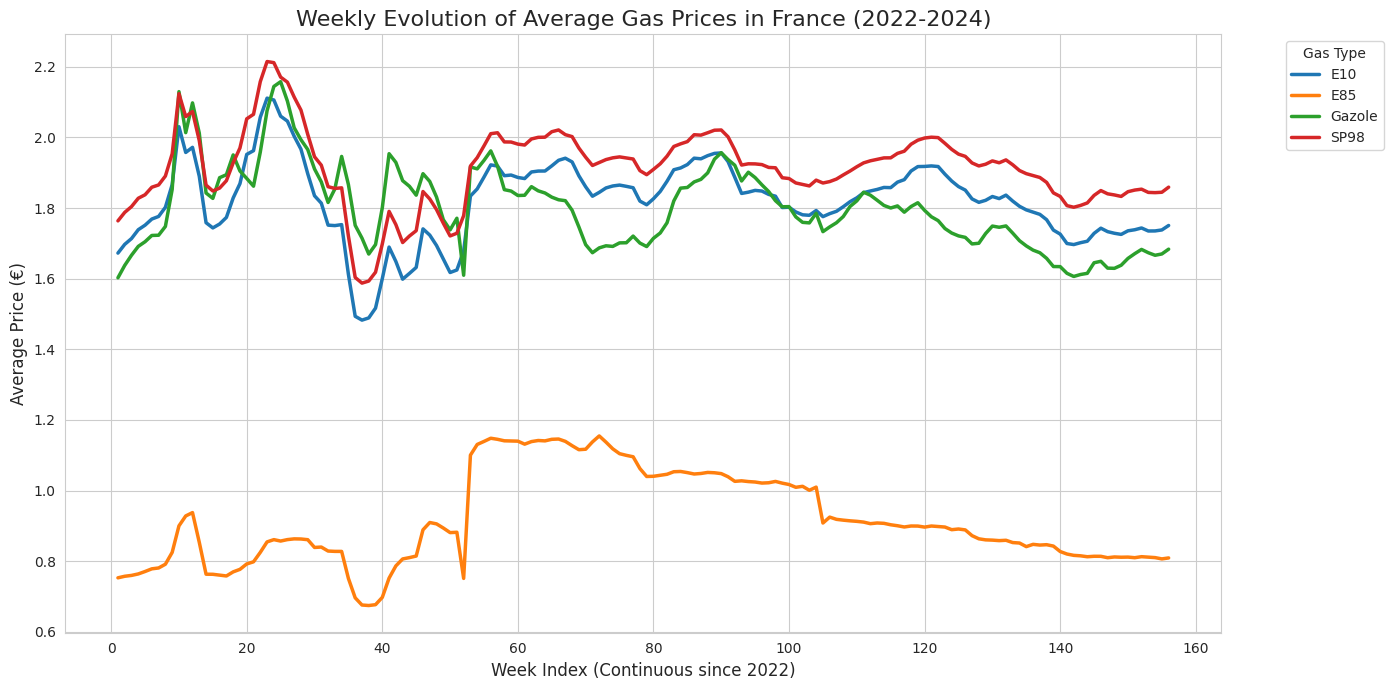

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# Data Visualization (Page 6)
# ==========================================

# 1. Aggregate Data in Spark
# We need the average price per week for each gas type
# Group by 'week_index' and 'name' -> Calculate average 'prix'
df_viz = df_final.groupBy("week_index", "name") \
    .agg(avg("prix").alias("avg_weekly_price")) \
    .orderBy("week_index", "name")

# 2. Convert to Pandas for Plotting
# This is efficient because the result is very small (< 1000 rows)
pdf_viz = df_viz.toPandas()

# 3. Create the Plot
plt.figure(figsize=(14, 7))

# Use Seaborn to draw the lines
# hue='name' automatically creates a separate colored line for each gas type
sns.set_style("whitegrid")
sns.lineplot(data=pdf_viz, x="week_index", y="avg_weekly_price", hue="name", linewidth=2.5)

# 4. Formatting
plt.title("Weekly Evolution of Average Gas Prices in France (2022-2024)", fontsize=16)
plt.xlabel("Week Index (Continuous since 2022)", fontsize=12)
plt.ylabel("Average Price (€)", fontsize=12)
plt.legend(title="Gas Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
from pyspark.sql.functions import substring, col, avg
from src.visualization import plot_department_map


In [2]:
from pyspark.sql import functions as F
from src.visualization import plot_department_map

# ==========================================
# Phase 5: Bonus Visualization (Map)
# ==========================================

# 1. Prepare Data: Use df_final (NOT df_viz)
# We need to extract the department from 'cp' (Postal Code)
# lpad ensures 1000 becomes "01000" so substring gets "01" (Ain) instead of "10"
df_map_prep = df_final.withColumn("cp_fixed", F.lpad(F.col("cp").cast("string"), 5, "0")) \
                      .withColumn("dept", F.substring(F.col("cp_fixed"), 1, 2))

# 2. Aggregate: Average Price Index per Department
df_dept = df_map_prep.groupBy("dept", "name") \
    .agg(F.avg("price_index").alias("avg_index"))

# 3. Convert to Pandas for Plotting
pdf_dept = df_dept.toPandas()

# 4. Filter for specific gas type
target_gas = "SP98"
data_to_map = pdf_dept[pdf_dept['name'] == target_gas]

# 5. Generate Map
# Ensure you imported plot_department_map from src.visualization
map_viz = plot_department_map(data_to_map, target_gas, metric_col="avg_index")

# Display
map_viz

ModuleNotFoundError: No module named 'src'

In [35]:
output_path = os.path.join(project_root, "data", "processed", "gas_price_map.html")
map_viz.save(output_path)

print(f"Map saved to: {output_path}")

Map saved to: /home/ensai/Desktop/spark/france-gas-price/data/processed/gas_price_map.html


# Modeling – Forecast next day price

In [36]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# ==========================================
# Phase 6: Modeling (Forecast Next Day)
# ==========================================

print("Generating Lag Features...")

# 1. Define Window Specification
# We partition by Station (id) and Gas Type (name) to ensure we don't mix data between stations
# We order by time to correctly look "backwards"
window_spec = Window.partitionBy("id", "name").orderBy("day_date")

# 2. Create Lag Features (The "Window" from the paper)
# Lag 1: Yesterday's price
# Lag 2: 2 days ago
# Lag 3: 3 days ago
# Lag 7: Same day last week
df_features = df_final \
    .withColumn("price_lag_1", lag("prix", 1).over(window_spec)) \
    .withColumn("price_lag_2", lag("prix", 2).over(window_spec)) \
    .withColumn("price_lag_3", lag("prix", 3).over(window_spec)) \
    .withColumn("price_lag_7", lag("prix", 7).over(window_spec)) \
    .withColumn("rolling_avg_7", avg("prix").over(window_spec.rowsBetween(-7, -1)))

# 3. Drop missing values (The first few days won't have a "previous 7 days")
df_model_data = df_features.dropna()

print(f"Data prepared for modeling. Rows: {df_model_data.count()}")
df_model_data.select("day_date", "name", "prix", "price_lag_1", "price_lag_7").show(5)

Generating Lag Features...


Data prepared for modeling. Rows: 12403808


+----------+----+-----+-----------+-----------+
|  day_date|name| prix|price_lag_1|price_lag_7|
+----------+----+-----+-----------+-----------+
|2022-02-02|SP98|1.769|      1.744|      1.652|
|2022-02-05|SP98|1.744|      1.769|      1.652|
|2022-02-07|SP98|1.769|      1.744|      1.689|
|2022-02-09|SP98|1.813|      1.769|      1.708|
|2022-02-11|SP98|1.813|      1.813|      1.708|
+----------+----+-----+-----------+-----------+
only showing top 5 rows



In [37]:
# ==========================================
# Split Data (Time-Based)
# ==========================================

# Let's say we train on 2022-2023 and test on 2024 (or specific months)
# Check your data range first to pick a good split date
split_date = "2023-09-01" 

train_data = df_model_data.filter(col("day_date") < split_date)
test_data = df_model_data.filter(col("day_date") >= split_date)

print(f"Training Rows: {train_data.count()}")
print(f"Testing Rows:  {test_data.count()}")

Training Rows: 6903343


Testing Rows:  5500465


In [ ]:
# ==========================================
# Train GBT Model
# ==========================================

# 1. Prepare Features Vector
# Spark ML requires all input features to be in a single column called "features"
feature_cols = [
    "price_lag_1", "price_lag_2", "price_lag_3", "price_lag_7", # Past prices
    "rolling_avg_7", # Trend
    "week", "month", "year", "lat", "long" # Context
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform data
train_vec = assembler.transform(train_data)
test_vec = assembler.transform(test_data)

# 2. Define Model (GBRT as per paper)
gbt = GBTRegressor(featuresCol="features", labelCol="prix", maxIter=20)

# 3. Traingbt = GBTRegressor(featuresCol="features", labelCol="prix", maxIter=20)

print("Training GBT Model... (This might take a minute)")
model = gbt.fit(train_vec)

print("Training Complete!")

Training GBT Model... (This might take a minute)


Training Complete!


In [39]:
# ==========================================
# Evaluation
# ==========================================

# 1. Make Predictions
predictions = model.transform(test_vec)

# 2. Calculate RMSE (Root Mean Squared Error)
evaluator = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# 3. Calculate MAE (Mean Absolute Error) - Easier to interpret
evaluator_mae = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"Interpretation: On average, the model's prediction is off by €{mae:.4f}")

# 4. Visualize Prediction vs Actual (First 20 rows)
predictions.select("day_date", "name", "prix", "prediction").show(20)

26/01/12 16:51:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Root Mean Squared Error (RMSE): 0.0525
Mean Absolute Error (MAE):      0.0271
Interpretation: On average, the model's prediction is off by €0.0271


+----------+----+-----+------------------+
|  day_date|name| prix|        prediction|
+----------+----+-----+------------------+
|2023-09-02|SP98|1.968| 1.923051034672347|
|2023-09-07|SP98|1.968| 1.923051034672347|
|2023-09-09|SP98|1.968| 1.923051034672347|
|2023-09-11|SP98|1.968|1.9614963480544976|
|2023-09-12|SP98|1.968|1.9658986604201192|
|2023-09-13|SP98|1.987|1.9658986604201192|
|2023-09-14|SP98|1.987| 1.973959492251225|
|2023-09-15|SP98|1.987| 1.973959492251225|
|2023-09-16|SP98|1.987| 1.973959492251225|
|2023-09-16|SP98|1.987| 1.973959492251225|
|2023-09-18|SP98|1.989| 1.973959492251225|
|2023-09-19|SP98|1.989| 1.973959492251225|
|2023-09-20|SP98|1.989|1.9795001926081848|
|2023-09-21|SP98|1.989|1.9795001926081848|
|2023-09-22|SP98|1.989|1.9795001926081848|
|2023-09-23|SP98|1.997|1.9795001926081848|
|2023-09-25|SP98|1.997|2.0083729125048566|
|2023-09-26|SP98|1.997|2.0083729125048566|
|2023-09-27|SP98|1.997|2.0083729125048566|
|2023-09-28|SP98|1.997|2.0083729125048566|
+----------

In [3]:
#linear regression/ random regressior
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, avg, round
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# ==========================================
# Phase 6: Modeling (Page 8 Requirements)
# Use Spark ML Standard Regressors (RF / LR)
# ==========================================

print("1. Feature Engineering (Window Strategy)...")

# Define Window: Partition by Station+Gas, Order by Time
window_spec = Window.partitionBy("id", "name").orderBy("day_date")

# Create Features: Lags (Yesterday, 2 days ago, Last Week) & Rolling Avg
df_features = df_final \
    .withColumn("price_lag_1", lag("prix", 1).over(window_spec)) \
    .withColumn("price_lag_2", lag("prix", 2).over(window_spec)) \
    .withColumn("price_lag_7", lag("prix", 7).over(window_spec)) \
    .withColumn("rolling_avg_7", avg("prix").over(window_spec.rowsBetween(-7, -1))) \
    .dropna()

# Prepare Vector for Spark ML
feature_cols = [
    "price_lag_1", "price_lag_2", "price_lag_7", # Auto-regressive features
    "rolling_avg_7",                             # Trend
    "week", "month", "year", "lat", "long"       # Seasonality & Location
]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_model_ready = assembler.transform(df_features)

# Split Data (Time-based split is best for Time Series)
split_date = "2023-09-01"
train_data = df_model_ready.filter(col("day_date") < split_date)
test_data = df_model_ready.filter(col("day_date") >= split_date)

print(f"Training Data: {train_data.count()} rows")
print(f"Testing Data:  {test_data.count()} rows")

1. Feature Engineering (Window Strategy)...


RuntimeError: SparkContext or SparkSession should be created first.

In [ ]:


# ==========================================
# Train Model: Random Forest Regressor
# ==========================================
# We use Random Forest as it captures non-linear relationships better than Linear Regression
# and is explicitly mentioned in Page 8.

rf = RandomForestRegressor(featuresCol="features", labelCol="prix", numTrees=50, maxDepth=10)

print("Training Random Forest Model... (This takes a moment)")
model = rf.fit(train_data)

# --- ALTERNATIVE: Linear Regression (If you want to compare) ---
# lr = LinearRegression(featuresCol="features", labelCol="prix")
# model = lr.fit(train_data)
# -------------------------------------------------------------

print("Training Complete!")

# ==========================================
# Evaluation & Forecast Export
# ==========================================

# Make Predictions
predictions = model.transform(test_data)

# Evaluate
evaluator_rmse = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="mae")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print(f"Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f} (Average error in Euros)")

# Save Forecasts for the Dashboard (App)
# We drop the 'features' vector column to save space
df_forecast_export = predictions.select("day_date", "name", "dept", "prix", "prediction")

output_path = "data/processed/model_forecasts.parquet"
df_forecast_export.write.mode("overwrite").parquet(output_path)
print(f"Forecasts saved to: {output_path}")

# Show sample
predictions.select("day_date", "name", "prix", "prediction").show(5)
